In [1]:
# Libraries
import os, glob, random, time, subprocess, math, tqdm
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path
from typing import Optional
from random import randint

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from numpy import linalg as LA
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from skimage.metrics import structural_similarity as ssim
import rasterio

# C2F custom
import utils.DataGeneratorC2 as DataGenerator

#### To Note: Cell2FireC is compiled in Linux

In [2]:
# Basic parameters and paths
BASE_PATH = '/Users/minho/Documents/GitHub/Cell2FireML/'
CELL2FIRE_PATH = os.path.join(BASE_PATH, 'Cell2FireW/')        # Cell2Fire binary
DATA_PATH = os.path.join(BASE_PATH, 'data/real/canada_dogrib')
WEATHERS_PATH = os.path.join(DATA_PATH, 'Weathers')
RESULTS_PATH = os.path.join(BASE_PATH, 'results', 'canada_dogrib_bbo_c2fconstants/')
RESULTS_PATH_NOBBO = os.path.join(BASE_PATH, 'results', 'canada_dogrib_nobbo_c2fconstants/')

# canada_dogrib_bbo_c2fconstants
# canada_dogrib_nobbo_c2fconstants

# Create output folder for MC-sampled simulation results
if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)
if not os.path.exists(WEATHERS_PATH):
    os.mkdir(WEATHERS_PATH)
if not os.path.exists(RESULTS_PATH):
    os.mkdir(RESULTS_PATH)
if not os.path.exists(RESULTS_PATH_NOBBO):
    os.mkdir(RESULTS_PATH_NOBBO)

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

## 1. Fire Weather Index (FWI)

<div style="text-align: center;">
    <h1 style="font-weight: bold;">Fire progression of the 2001 Dogrib Fire</h1>
</div>
<div style="text-align: center;">
    <img src="https://nhess.copernicus.org/articles/21/3141/2021/nhess-21-3141-2021-f03-thumb.png" width="500" alt="Dogrib fire image">
</div>
<div style="text-align: center;">
    <a href="https://nhess.copernicus.org/articles/21/3141/2021/nhess-21-3141-2021-f03-thumb.png">[Source]: Katan, J., & Perez, L. (2021). ABWiSE v1. 0: Toward and Agent-Based Approach to Simulating Wildfire Spread. Natural Hazards and Earth System Sciences Discussions, 2021, 1-27.</a>
</div>

#### Record of the fire's progression
**Start (Sep 25, 2001)**

The Dogrib fire started on September 25, 2001 in southwest Alberta due to an abandoned camp fire.

**Fire's initial progression (Sep 30 - Oct 15)**

The fire was 70 ha in size and burning out of control when assessed on September 30 at 09:54 MDT. The fire’s size continued to increase on September 30 reaching 95 ha at 10:46 MDT, 136 ha at 11:30 MDT, and 675 ha at 18:30 MDT. Fire fighting started October 1 at 06:00 MDT. The fire was classified as being held on October 2 at 08:00 MDT, and under control at 708 ha on October 4 at 10:00 MDT. Limited fire growth occurred between October 4 and 15. The fire grew by 19 and 15 ha on October 6 and 13 respectively. On October 15 the fire’s size increased to 852 ha at which time the status reverted to out of control. 

**Major fire run (Oct 16)**

A wind event resulted in a major fire run on October 16. Local terrain funneled wind flow along the Red Deer River, and through a gap in the surrounding mountains. This pushed the fire east along the river valley. The fire jumped the Red Deer River and an adjacent road and then resumed a northeast spread direction. The fire spread 19 km in 6.7 hrs for an average spread rate of 47.3 m/min.

#### 1.1 Examine 2001 Dogrib Fire weather

Yesterday’s daily starting codes for September 25 are as follows: FFMC 89, DMC 58, DC 482, Precip 0.0 mm. A value of 94 @ Hour 17 is recommended for today’s starting value if using the Hourly (Van Wagner) method to calculate HFFMC.

In [3]:
# Load paths
PATH_INPUT = os.path.join(BASE_PATH, 'data/real/Dogrib_v624/weather_B3_hourly_20010925to1030.csv')
PATH_OUTPUT = os.path.join(BASE_PATH, 'data/real/Dogrib_v624/output_df.csv')

# Load weather stream file for the full Dogrib Fire (Sep 25 - Oct 30)
dogrib_df = pd.read_csv(PATH_INPUT)

#### 1.2. Data exploration of 2001 Dogrib Fire

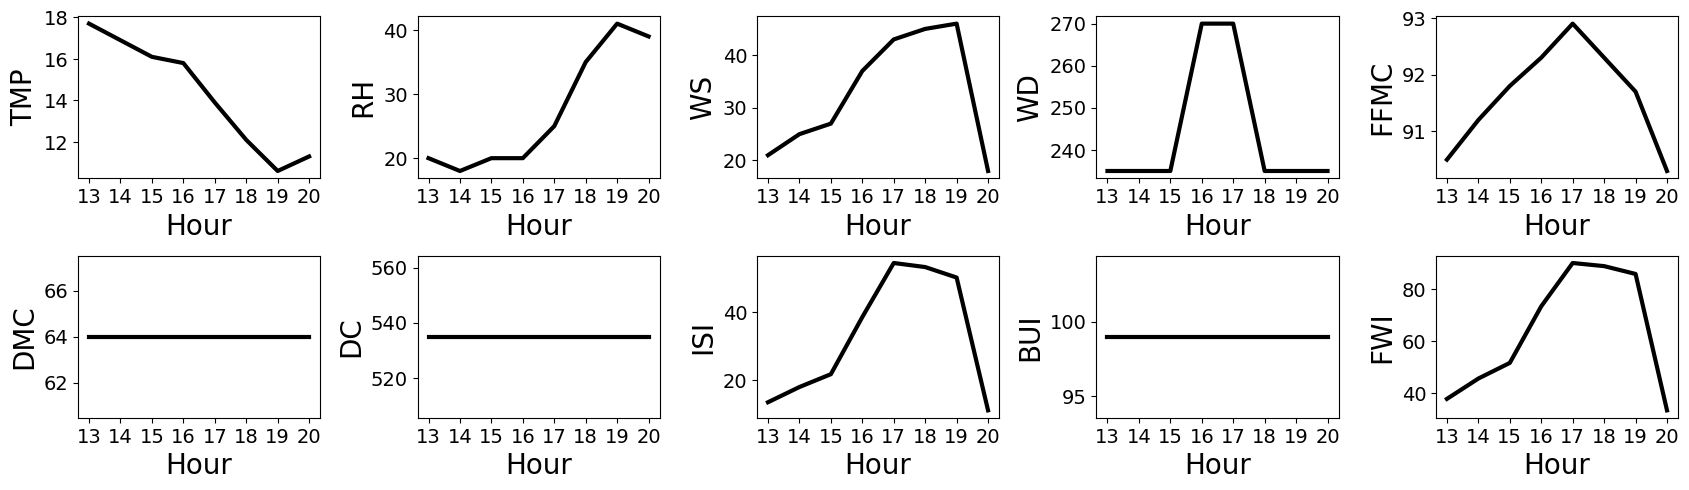

In [4]:
# Load weather stream file from Cell2Fire's main Github repo 
# which contains 8 hours from Oct 16 (largest fire run)
weather_df = pd.read_csv(os.path.join(DATA_PATH, 'Weather.csv'))

# Original C2F weather data for the 2001 Dogrib Fire
weather_df['date'] = [pd.to_datetime(i).hour for i in weather_df['datetime']]

# Plot
fig, axs = plt.subplots(2,5, figsize=(17,5))

for i, col in enumerate(['TMP','RH','WS','WD','FFMC','DMC','DC','ISI','BUI','FWI']):
    ax = axs.flatten()

    sns.lineplot(data=weather_df, x='date', y=col, color='k', legend=False,
                linewidth=3, label='Cell2Fire', ax=ax[i])
    
    ax[i].set_xticks(weather_df['date'])
    # ax[i].set_xticklabels(weather_df['date'][::5], rotation=45, size=20)
    ax[i].set_xlabel('Hour', size=20)
    ax[i].set_ylabel(col, size=20)

    ax[i].tick_params(axis='both', labelsize=14)  # Increase tick label size

plt.tight_layout()
plt.show()

## 2. Cell2Fire
- 3.0: Cell2Fire and Prometheus (Assumed)
- 3.1: Cell2Fire + BBO
- 3.2: 

In [11]:
# Turns a dictionary into a class
class Dict2Class(object):
    def __init__(self, my_dict):
        for key in my_dict:
            setattr(self, key, my_dict[key])

# Pre-processing: Generate the Data.csv file for the C++ core
def generateDataC(args):
    dataName = os.path.join(args.InFolder, "Data.csv")
    if os.path.isfile(dataName) is False:
        print("Generating Data.csv File...")
        DataGenerator.GenDataFile(args.InFolder)    
                    
# Run C++ Sim 
def run(cell2fire_path, args, verbose=False):
    # Parse args for calling C++ via subprocess        
    # old: execArray=[os.path.join(os.getcwd(),'Cell2FireC/Cell2Fire'), 
    execArray=[os.path.join(cell2fire_path,'Cell2Fire'), 
               '--input-instance-folder', args.InFolder,
               '--output-folder', args.OutFolder if (args.OutFolder is not None) else '',
               '--ignitions' if (args.ignitions) else '',
               '--sim-years', str(args.sim_years),
               '--sim', "C",
               '--nsims', str(args.nsims),
               '--grids' if (args.grids) else '', 
               '--final-grid' if (args.finalGrid) else '',
               '--Fire-Period-Length', str(args.input_PeriodLen),
               '--output-messages' if (args.OutMessages) else '',
               '--weather', args.WeatherOpt,
               '--nweathers', str(args.nweathers),
               '--ROS-CV', str(args.ROS_CV),
               '--IgnitionRad', str(args.IgRadius), 
               '--seed', str(int(args.seed)),
               '--nthreads', str(int(args.nthreads)),
               '--ROS-Threshold', str(args.ROS_Threshold),
               '--HFI-Threshold', str(args.HFI_Threshold),
               '--HFactor', str(args.HFactor),
               '--BFactor', str(args.BFactor),
               '--FFactor', str(args.FFactor),
               '--EFactor', str(args.EFactor),
               '--bbo' if (args.BBO) else '',
               '--mcnumber', str(args.mcnumber),
            #    '--scenario' if str(args.scenario) else '',
               '--HarvestPlan', args.HCells if(args.HCells is not None) else '',
               '--verbose' if (args.verbose) else '',]

    # Print exec array
    if verbose:
        print('ExecArray:', ' '.join(execArray))
    
    # Output log
    if args.OutFolder is not None:
        if os.path.isdir(args.OutFolder) is False:
            os.makedirs(args.OutFolder)
        LogName = os.path.join(args.OutFolder, "LogFile.txt")
    else:
        LogName = os.path.join(args.InFolder, "LogFile.txt")   

    # Perform the call
    with open(LogName, 'w') as output:
        proc = subprocess.Popen(execArray, stdout=output)
        proc.communicate()
    return_code = proc.wait()
    if (return_code != 0):
        raise RuntimeError(f'C++ returned {return_code}.\nTry looking at {LogName}.') 

    # End of the replications
    # print("End of Cell2FireC execution...")

In [12]:
'''
Metrics:
- ADI
- Sorensen index (Dice)
- F1-score
'''

def compute_ADI(result_c2f, result_farsite):

    # Flatten
    result_c2f = result_c2f.flatten()
    result_farsite = result_farsite.flatten()        

    # Intersection (I) - Cells burned in both models
    intersection = np.sum((result_c2f == 1) & (result_farsite == 1))

    # Overestimation (OE) - Burned in Cell2Fire but NOT in FARSITE
    overestimation = np.sum((result_c2f == 1) & (result_farsite == 0))

    # Underestimation (UE) - Burned in FARSITE but NOT in Cell2Fire
    underestimation = np.sum((result_c2f == 0) & (result_farsite == 1))

    # Calculate ADI (Area Difference Index)
    ADI = (overestimation + underestimation) / intersection         # ADI (Area Difference Index)
    ADIue = underestimation / intersection                          # ADIue (Underestimation Index)
    ADIoe = overestimation / intersection                           # ADIoe (Overestimation Index)

    # Edge effect
    if intersection == 0:
        ADI, ADIue, ADIoe = np.nan, np.nan, np.nan
        # print("No overlap between the predicted and observed fire perimeters. ADI metrics cannot be calculated.")

    return ADI, ADIue, ADIoe


def compute_sorensen(result_c2f, result_farsite):

    # Flatten
    result_c2f = result_c2f.flatten()
    result_farsite = result_farsite.flatten()        

    # Calculate intersection (correctly predicted burned area)
    intersection = np.sum((result_c2f == 1) & (result_farsite == 1))

    # Calculate total burned areas
    area_cell2fire = np.sum(result_c2f == 1)
    area_farsite = np.sum(result_farsite == 1)

    # Sorensen-Dice Index (SDI) Calculation
    if (area_cell2fire + area_farsite) == 0:
        SDI = np.nan  # Avoid division by zero if no burned area in both grids
    else:
        SDI = (2 * intersection) / (area_cell2fire + area_farsite)

    return SDI

def compute_f1_score(result_c2f, result_farsite):

    # Flatten
    result_c2f = result_c2f.flatten()
    result_farsite = result_farsite.flatten()        

    # Define burned and unburned regions
    # 1 = burned, 0 = unburned
    burned_cell2fire = (result_c2f == 1).astype(int)
    burned_farsite = (result_farsite == 1).astype(int)

    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    TP = np.sum((burned_cell2fire == 1) & (burned_farsite == 1))  # Correctly predicted burned
    FP = np.sum((burned_cell2fire == 1) & (burned_farsite == 0))  # Overestimated (False Positive)
    FN = np.sum((burned_cell2fire == 0) & (burned_farsite == 1))  # Underestimated (False Negative)

    # Calculate Precision and Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Calculate F1 Score
    if (precision + recall) == 0:
        F1 = 0  # Avoid division by zero
    else:
        F1 = (2 * precision * recall) / (precision + recall)

    return F1, precision, recall

In [13]:
# Cell2Fire binary

# Input instance
INSTANCE_PATH = os.path.join(DATA_PATH, '../')
instance_name = 'dogrib'

# Results folder
OUT_PATH = os.path.join(RESULTS_PATH, '../results_paper_canada/')
if not os.path.exists(OUT_PATH):
    os.mkdir(OUT_PATH)

# Reference 
df_reference = pd.read_csv(os.path.join(DATA_PATH, 'real_scar_dogrib.csv'), header=None, delimiter=' ')

#### 3.0. C2F with no BBO

In [27]:
CELL2FIRE_PATH = '/Users/minho/Documents/GitHub/Cell2FireML/Cell2FireC_Canada'

In [28]:
# Set new instance
out_name = 'dogrib_no_tune'

# Cell2Fire options
args = {
    'InFolder': INSTANCE_PATH + instance_name + '/',
    'OutFolder': OUT_PATH + out_name + '/',
    'ignitions': True,
    'sim_years': 1,
    'nsims': 1,
    'Simulator': 'C',
    'grids': False, 
    'finalGrid': True,
    'input_PeriodLen': 0.1,
    'OutMessages': False,
    'WeatherOpt': 'rows',
    'nweathers': 1,
    'ROS_CV': 0.0,
    'IgRadius': 0, 
    'seed': 123,
    'mcnumber':0,
    'ROS_Threshold':0.0,
    'HFI_Threshold':0.0,
    'HFactor':1.0,
    'BFactor':1.0,
    'FFactor':1.0,
    'EFactor':2.0,
    'nthreads':1,
    'BBO': False,
    'HCells': None,
    'verbose': False,
}

# Convert to object
args_obj = Dict2Class(args)

# Generate data if needed
generateDataC(args_obj)
              
# Execution
run(cell2fire_path=CELL2FIRE_PATH, args=args_obj, verbose=True)

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireC_Canada/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib/../dogrib/ --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/canada_dogrib_bbo_c2fconstants/../results_paper_canada/dogrib_no_tune/ --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 1.0 --BFactor 1.0 --FFactor 1.0 --EFactor 2.0  --mcnumber 0 --HarvestPlan  


OSError: [Errno 8] Exec format error: '/Users/minho/Documents/GitHub/Cell2FireML/Cell2FireC_Canada/Cell2Fire'

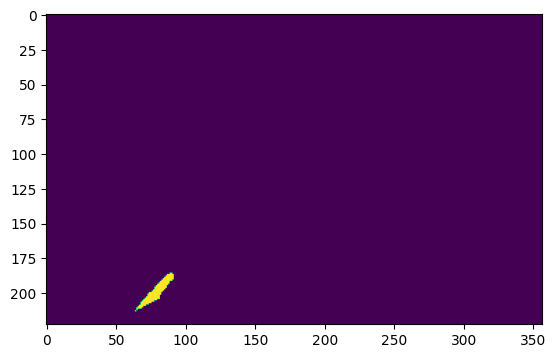

In [20]:
# Visualize Cell2Fire result
dogrib_c2f = pd.read_csv(glob.glob(os.path.join(args['OutFolder'], "Grids/Grids1/ForestGrid*.csv"))[0], header=None)
plt.imshow(dogrib_c2f)
plt.show()

In [27]:
# Set new instance
instance_name = 'dogrib'
out_name = 'dogrib_prom'

# Update parameters
args['input_PeriodLen'] = 0.1
args['HFactor'] = 1.0
args['FFactor'] = 1.0
args['BFactor'] = 1.0
args['EFactor'] = 1.9
args['BBO'] = False

# args_obj = update_args_full_paths(instance_path=instance_path, intance_name=instance_name, out_name=out_name)
args_obj = Dict2Class(args)
# Generate data if needed
generateDataC(args_obj)

# Execution
run(cell2fire_path=CELL2FIRE_PATH, args=args_obj, verbose=True)

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib/../dogrib/ --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/canada_dogrib_bbo_c2fconstants/../results_paper_canada/dogrib_no_tune/ --ignitions --sim-years 1 --nsims 1 --sim C  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 1.0 --BFactor 1.0 --FFactor 1.0 --EFactor 1.9  --mcnumber 0 --HarvestPlan  


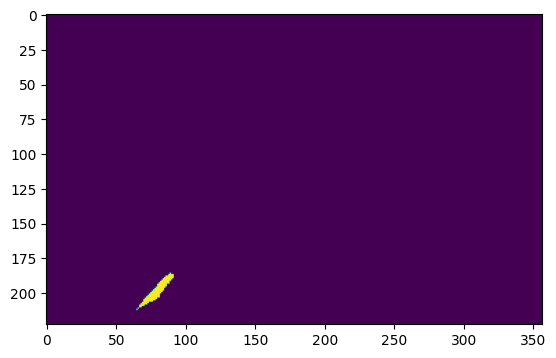

In [28]:
# Visualize Prometheus result
dogrib_prom = pd.read_csv(glob.glob(os.path.join(args['OutFolder'], "Grids/Grids1/ForestGrid*.csv"))[0], header=None)
plt.imshow(dogrib_prom)
plt.show()

In [21]:
# Comparison with non-tuned optimal C2F result
in2 = np.array(df_reference)
dogrib_c2f_np = np.array(dogrib_c2f)

# Compute evaluation metrics
ADI, ADIue, ADIoe = compute_ADI(dogrib_c2f_np, in2)
norm = LA.norm(dogrib_c2f_np - in2)
mse = ((dogrib_c2f_np - in2)**2).mean()
f1 = f1_score(in2.flatten() , dogrib_c2f_np.flatten(), average='macro')
ssim_sc = ssim(dogrib_c2f_np, in2, data_range=1)
area_in1 = len(dogrib_c2f_np[dogrib_c2f_np == 1])
area_in2 = len(in2[in2 == 1])
r2 = r2_score(dogrib_c2f_np, in2)


# Populate
df_no_opt = pd.DataFrame({
    "Instance": [instance_name],
    "ADI": np.round(ADI, 4),
    "ADIue": np.round(ADIue,4),
    "ADIoe": np.round(ADIoe,4), 
    "F1": np.round(f1,4),
    "SSIM": np.round(ssim_sc,4),
    "MSE": np.round(mse,4),
    "norm": np.round(norm,4),
    "AreaC2F": area_in1,
    "AreaRef": area_in2
})

df_no_opt["RMSE"] = np.sqrt(df_no_opt["MSE"]) # Also add RMSE
df_no_opt

,Instance,ADI,ADIue,ADIoe,F1,SSIM,MSE,norm,AreaC2F,AreaRef,RMSE
0,dogrib,65.5779,65.2987,0.2792,0.4809,0.8145,0.1269,100.4938,197,10210,0.35623


In [22]:
# Let's also add Prometheus to compare
prom_path = os.path.join(DATA_PATH, 'prometheus_dogrib.csv')

# Compute evaluation metrics
df_prom = pd.read_csv(prom_path, header=None, delimiter=' ')
in1 = np.array(df_prom)

ADI, ADIue, ADIoe = compute_ADI(in1, in2)
norm = LA.norm(in1 - in2)
mse = ((in1 - in2)**2).mean()
f1 = f1_score(in2.flatten() , in1.flatten(), average='macro')
ssim_sc = ssim(in1, in2, data_range=1)
area_in1 = len(in1[in1 == 1])
area_in2 = len(in2[in2 == 1])

# Populate
df_temp_prom = pd.DataFrame({
    "Instance": [instance_name],
    "ADI": np.round(ADI, 4),
    "ADIue": np.round(ADIue,4),
    "ADIoe": np.round(ADIoe,4), 
    "F1": np.round(f1,4),
    "SSIM": np.round(ssim_sc,4),
    "MSE": np.round(mse,4),
    "RMSE": np.round(np.sqrt(mse),4),
    "norm": np.round(norm,4),
    "AreaC2F": area_in1,
    "AreaRef": area_in2
})

df_temp_prom["Source"] = "PROM"

ValueError: operands could not be broadcast together with shapes (223,) (79611,) 

In [23]:
err_min = (df_no_opt['RMSE'] * 0.95)[0]
err_max = (df_no_opt['RMSE'] * 1.05)[0]

#### 3.1. C2F with BBO

In [26]:
# Cell2Fire options
args = {
    'InFolder': INSTANCE_PATH + instance_name + '/',
    'OutFolder': OUT_PATH + out_name + '/',
    'ignitions': True,
    'sim_years': 1,
    'nsims': 1,
    'grids': False, 
    'finalGrid': True,
    'input_PeriodLen': 0.1,
    'OutMessages': False,
    'WeatherOpt': 'rows',
    'nweathers': 1,
    'ROS_CV': 0.0,
    'IgRadius': 0, 
    'seed': 123,
    'mcnumber':0,
    'ROS_Threshold':0.0,
    'HFI_Threshold':0.0,
    'HFactor':1.0,
    'BFactor':1.0,
    'FFactor':1.0,
    'EFactor':1.0,
    'nthreads':1,
    'BBO': True,
    'HCells': None,
    'verbose': True,
}

# Set new instance
out_name = 'dogrib_bbo'

# Generate data if needed
generateDataC(args_obj)

# Convert to object
args_obj = Dict2Class(args)
              
# Execution
run(cell2fire_path=CELL2FIRE_PATH, args=args_obj, verbose=True)

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib/../dogrib/ --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/canada_dogrib_bbo_c2fconstants/../results_paper_canada/dogrib_bbo/ --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 1.0 --BFactor 1.0 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 0 --HarvestPlan  --verbose


RuntimeError: C++ returned -11.
Try looking at /Users/minho/Documents/GitHub/Cell2FireML/results/canada_dogrib_bbo_c2fconstants/../results_paper_canada/dogrib_bbo/LogFile.txt.

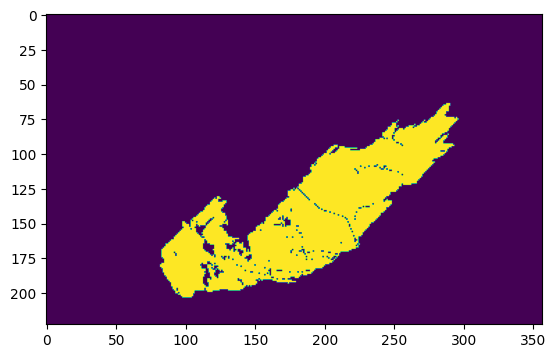

In [ ]:
# Visualize C2F with BBO result
dogrib_sim = pd.read_csv(glob.glob(os.path.join(args['OutFolder'], "Grids/Grids1/ForestGrid*.csv"))[0], header=None)

plt.imshow(dogrib_sim)
plt.show()

In [ ]:
# Comparison with BBO-tuned optimal C2F result
in2 = np.array(df_reference)
dogrib_sim_np = np.array(dogrib_sim)

# Compute evaluation metrics
ADI, ADIue, ADIoe = compute_ADI(dogrib_sim_np, in2)
norm = LA.norm(dogrib_sim_np - in2)
mse = ((dogrib_sim_np - in2)**2).mean()
f1 = f1_score(in2.flatten() , dogrib_sim_np.flatten(), average='macro')
ssim_sc = ssim(dogrib_sim_np, in2, data_range=1)
area_in1 = len(dogrib_sim_np[dogrib_sim_np == 1])
area_in2 = len(in2[in2 == 1])

# Populate
df_bbo_opt = pd.DataFrame({
    "Instance": [instance_name + '+BBO'],
    "ADI": np.round(ADI, 4),
    "ADIue": np.round(ADIue,4),
    "ADIoe": np.round(ADIoe,4), 
    "F1": np.round(f1,4),
    "SSIM": np.round(ssim_sc,4),
    "MSE": np.round(mse,4),
    "norm": np.round(norm,4),
    "AreaC2F": area_in1,
    "AreaRef": area_in2
})

df_bbo_opt["RMSE"] = np.sqrt(df_bbo_opt["MSE"])
df_bbo_opt

,Instance,ADI,ADIue,ADIoe,F1,SSIM,MSE,norm,AreaC2F,AreaRef,RMSE
0,dogrib+BBO,0.8712,0.4153,0.4559,0.8256,0.8181,0.0789,79.278,10503,10210,0.280891


In [ ]:
err_opt_min = (df_bbo_opt['RMSE'] * 0.95)[0]
err_opt_max = (df_bbo_opt['RMSE'] * 1.05)[0]

In [ ]:
# Error ranges
print("Filter ranges: {}".format([err_min, err_max]))
print("Filter ranges: {}".format([err_opt_min, err_opt_max]))

Filter ranges: [0.3160802904326684, 0.34935189995189664]
Filter ranges: [0.2668468661985746, 0.2949360100089509]
